In [1]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import sys
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import missingno as msno
from statsmodels.tools import add_constant
from sklearn.preprocessing import StandardScaler
from skorch import NeuralNetClassifier
import torch
from torch import nn
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer


In [2]:
# Version of Python WE used
print('Python==' + str(sys.version))



Python==3.9.13 (main, Aug 25 2022, 18:29:29) 
[Clang 12.0.0 ]


In [3]:
# Version numbers of libraries we used
print('pandas==' + str(pd.__version__))
print('matplotlib==' + str(sys.modules[plt.__package__].__version__))
print('numpy==' + str(np.__version__))
print('seaborn==' + str(sns.__version__))
print('missingno==' + str(msno.__version__))
print('statsmodels==' + str(sys.modules[add_constant.__module__[:add_constant.__module__.index(".")]].__version__))
print('scikit-learn==' + str(sys.modules[StandardScaler.__module__[:StandardScaler.__module__.index(".")]].__version__))
print('torch==' + str(torch.__version__))
print('skorch==' + str(sys.modules[NeuralNetClassifier.__module__[:NeuralNetClassifier.__module__.index(".")]].__version__))
print('imbalanced-learn==' + str(sys.modules[SMOTE.__module__[:SMOTE.__module__.index(".")]].__version__))

pandas==1.4.4
matplotlib==3.5.2
numpy==1.21.5
seaborn==0.11.2
missingno==0.5.2
statsmodels==0.13.2
scikit-learn==1.0.2
torch==2.0.0
skorch==0.12.1
imbalanced-learn==0.10.1


In [4]:
red_wine = pd.read_csv('winequality-red.csv', sep=';')
white_wine = pd.read_csv('winequality-white.csv', sep=';')

# Add a column to each dataset to indicate wine type
red_wine['wine_type'] = 'red'
white_wine['wine_type'] = 'white'
#Add class labels
red_wine["wine_type"] = 0
white_wine["wine_type"] = 1

# Combine the two datasets into a single dataframe
df = pd.concat([red_wine, white_wine], ignore_index=True)


In [5]:
df.head(5)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


In [6]:
print(f"The dataset has {df.shape[0]:.0f} rows and {df.shape[1]:.0f} columns.")


The dataset has 6497 rows and 13 columns.


In [7]:
# Inspect data types of the columns
df.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
wine_type                 int64
dtype: object

In [8]:

df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378,0.753886
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255,0.430779
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000,1.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,1.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000,1.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,1.000000


In [9]:
# Checking the distribution of the target variable (quality)
print(df['quality'].value_counts())


6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64


In [10]:
# Calculate the summary statistics
summary = df.describe()

# Transpose the summary table
summary = summary.T

# Add a column for the data type
summary.insert(1, "Data Type", df.dtypes)

# Print the summary table
print(summary)




                       count Data Type        mean        std      min  \
fixed acidity         6497.0   float64    7.215307   1.296434  3.80000   
volatile acidity      6497.0   float64    0.339666   0.164636  0.08000   
citric acid           6497.0   float64    0.318633   0.145318  0.00000   
residual sugar        6497.0   float64    5.443235   4.757804  0.60000   
chlorides             6497.0   float64    0.056034   0.035034  0.00900   
free sulfur dioxide   6497.0   float64   30.525319  17.749400  1.00000   
total sulfur dioxide  6497.0   float64  115.744574  56.521855  6.00000   
density               6497.0   float64    0.994697   0.002999  0.98711   
pH                    6497.0   float64    3.218501   0.160787  2.72000   
sulphates             6497.0   float64    0.531268   0.148806  0.22000   
alcohol               6497.0   float64   10.491801   1.192712  8.00000   
quality               6497.0     int64    5.818378   0.873255  3.00000   
wine_type             6497.0     int64

In [11]:
# Checking for null data
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
wine_type               0
dtype: int64

In [12]:
# Checking for duplicates
print(df.duplicated().sum())

1177


In [13]:
# Removing duplicates
df.drop_duplicates(inplace=True)


In [14]:
df.size

69160

In [15]:
df.shape

(5320, 13)

In [16]:
columns = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
           'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

for col in columns:
    num_zeros = (df[col] == 0).sum()
    percent_zeros = num_zeros / len(df) * 100
    print(f"{col.capitalize()}: there are {num_zeros} ({percent_zeros:.2f}%) rows with zero value.")


Fixed acidity: there are 0 (0.00%) rows with zero value.
Volatile acidity: there are 0 (0.00%) rows with zero value.
Citric acid: there are 136 (2.56%) rows with zero value.
Residual sugar: there are 0 (0.00%) rows with zero value.
Chlorides: there are 0 (0.00%) rows with zero value.
Free sulfur dioxide: there are 0 (0.00%) rows with zero value.
Total sulfur dioxide: there are 0 (0.00%) rows with zero value.
Density: there are 0 (0.00%) rows with zero value.
Ph: there are 0 (0.00%) rows with zero value.
Sulphates: there are 0 (0.00%) rows with zero value.
Alcohol: there are 0 (0.00%) rows with zero value.


In [17]:
print(df["quality"].describe())


count    5320.000000
mean        5.795677
std         0.879772
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         9.000000
Name: quality, dtype: float64


In [18]:
# create a new column for binary target variable
from sklearn.preprocessing import Binarizer

binarizer = Binarizer(threshold=6)
df["binary_quality"] = binarizer.fit_transform(df["quality"].values.reshape(-1, 1))

# drop the original "quality" column
df = df.drop("quality", axis=1)

# print the unique values in the binary_quality column
print(df["binary_quality"].unique())

[0 1]


In [19]:
# Number of data in the two target classes
df.binary_quality.value_counts()

0    4311
1    1009
Name: binary_quality, dtype: int64

In [25]:
import plotly.express as px

# count the number of data points in each class
class_counts = df["binary_quality"].value_counts()

# create a dataframe of the class counts
df_counts = pd.DataFrame({"Quality Rating": ["Less than 6", "Greater than or equal to 6"], "Count": class_counts})

# create a bar chart with hover information
fig = px.bar(df_counts, x="Quality Rating", y="Count", color="Quality Rating", hover_data=["Count"], 
             labels={"Quality Rating": "Quality Rating", "Count": "Count"}, title="Distribution of Wine Quality Ratings")

# set the font size and color of the title
fig.update_layout(title={"text": "Distribution of Wine Quality Ratings", "font": {"size": 24, "color": "black"}})

# set the font size and color of the x-axis and y-axis labels
fig.update_layout(xaxis={"title": {"font": {"size": 16, "color": "black"}}})
fig.update_layout(yaxis={"title": {"font": {"size": 16, "color": "black"}}})

# set the font size and color of the x-axis and y-axis tick labels
fig.update_layout(xaxis_tickfont_size=12, yaxis_tickfont_size=12, xaxis_tickfont_color="black", yaxis_tickfont_color="black")

# set the color of the hover label background and font
fig.update_traces(hoverlabel=dict(bgcolor="#ffffff", font=dict(size=14, color="black")))

# add a horizontal line to the chart at the midpoint of the y-axis
fig.add_shape(type="line", x0=-0.5, x1=1.5, y0=sum(class_counts)/2, y1=sum(class_counts)/2,
              line=dict(color="gray", width=2, dash="dash"))

# add a label to the horizontal line
fig.add_annotation(x=1, y=sum(class_counts)/2+100, text="Median: {:.0f}".format(sum(class_counts)/2),
                   showarrow=False, font=dict(size=16, color="gray"))

# show the plot
fig.show()



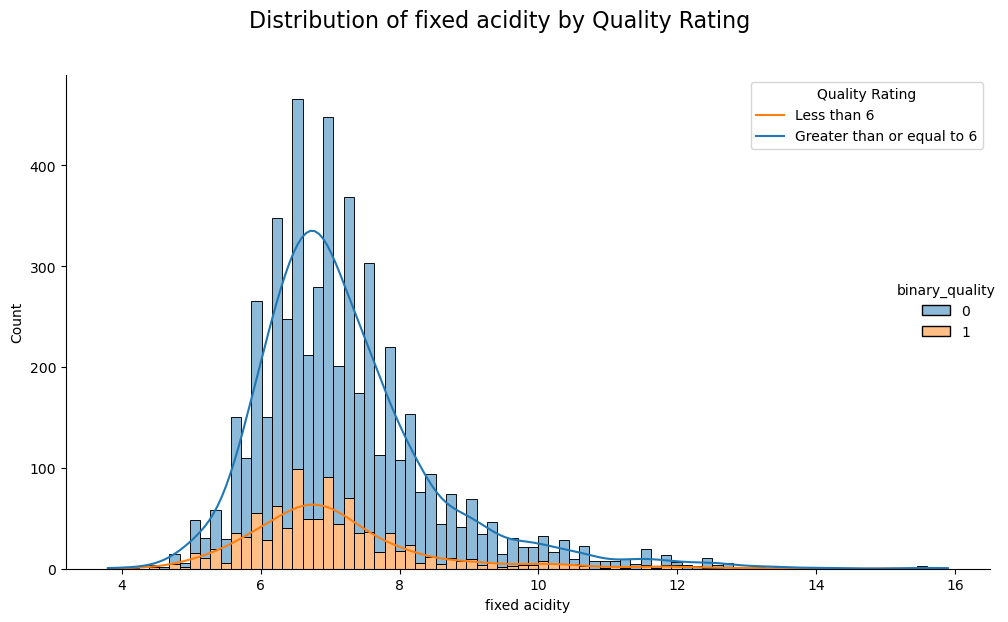

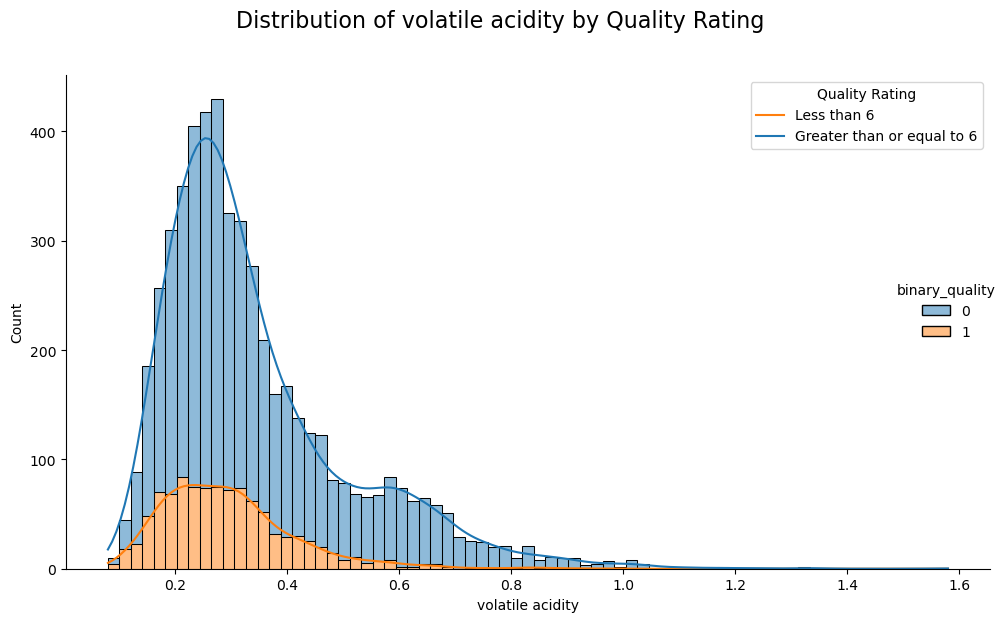

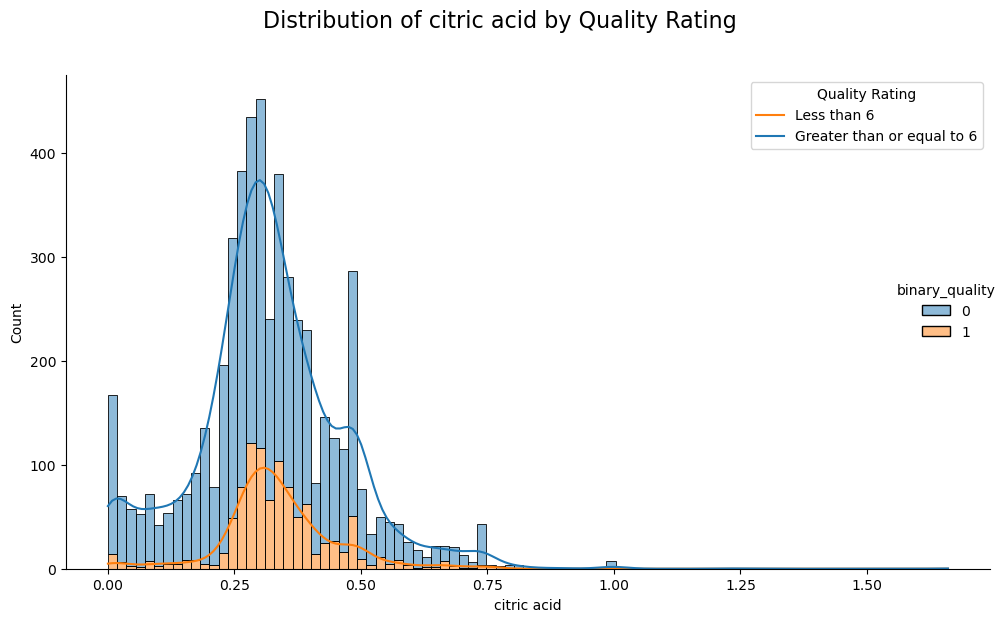

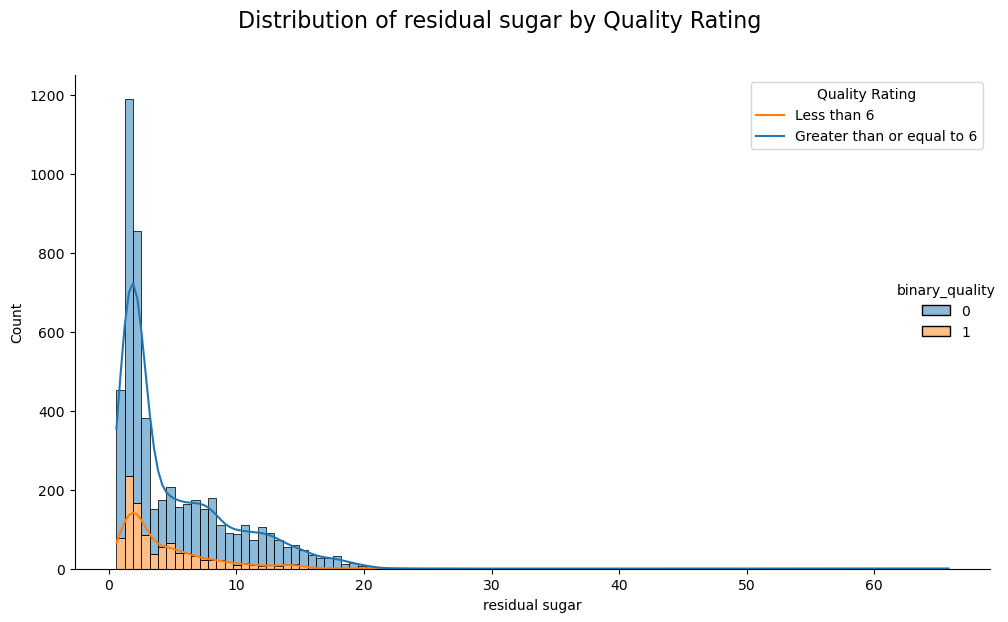

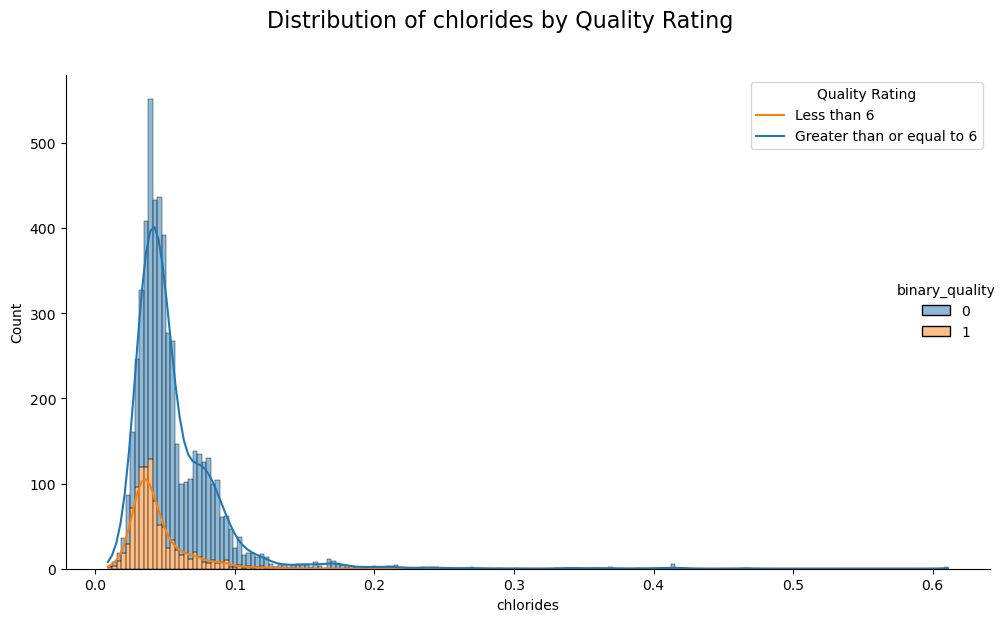

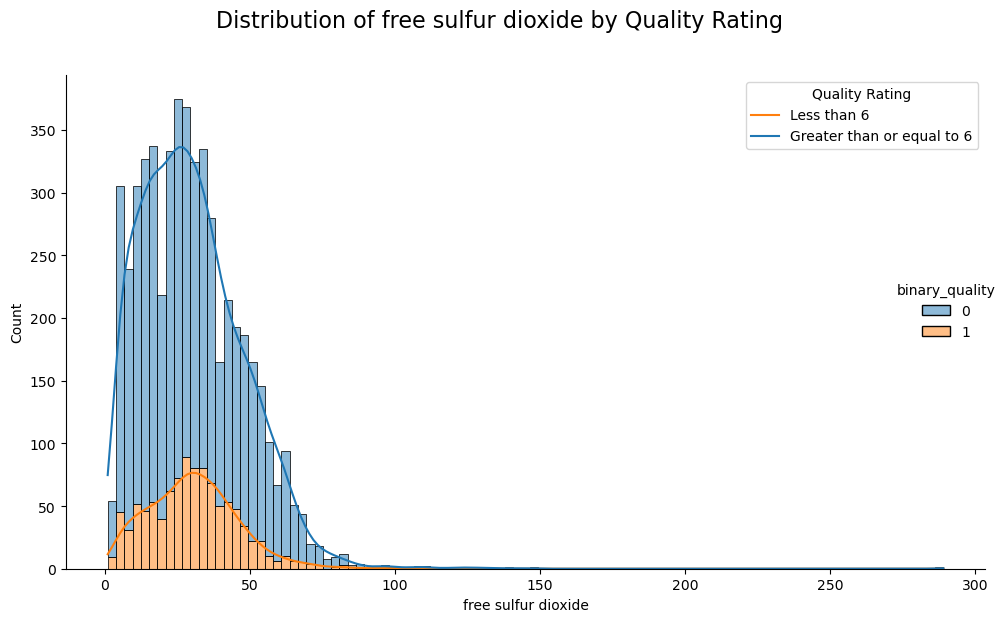

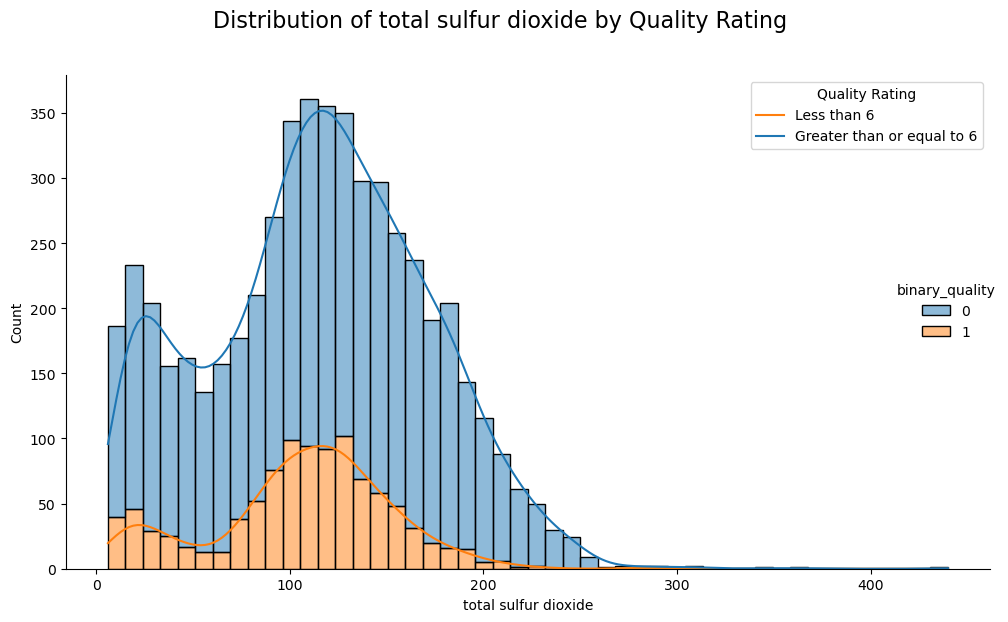

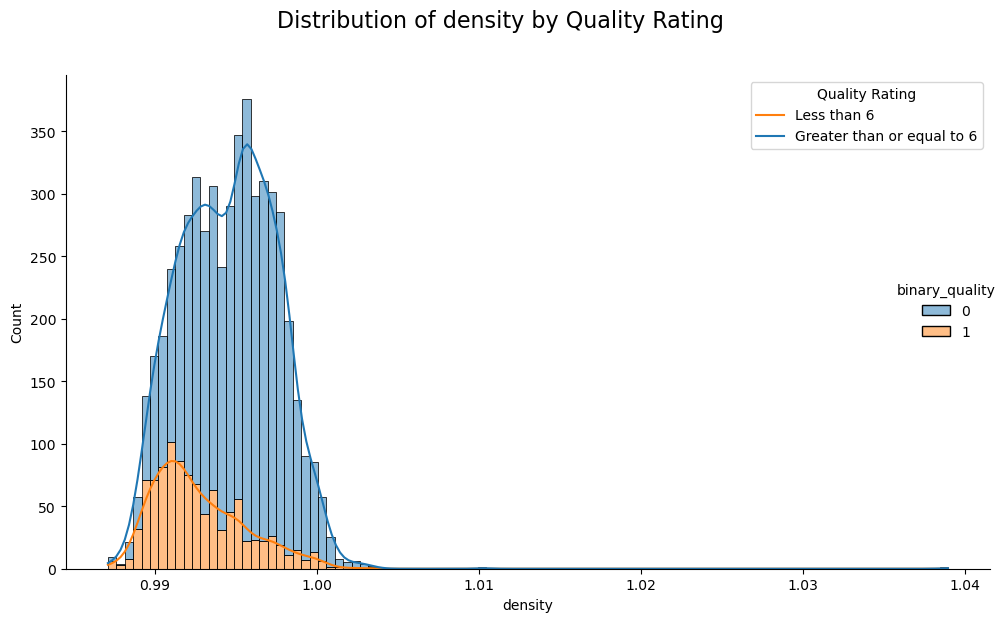

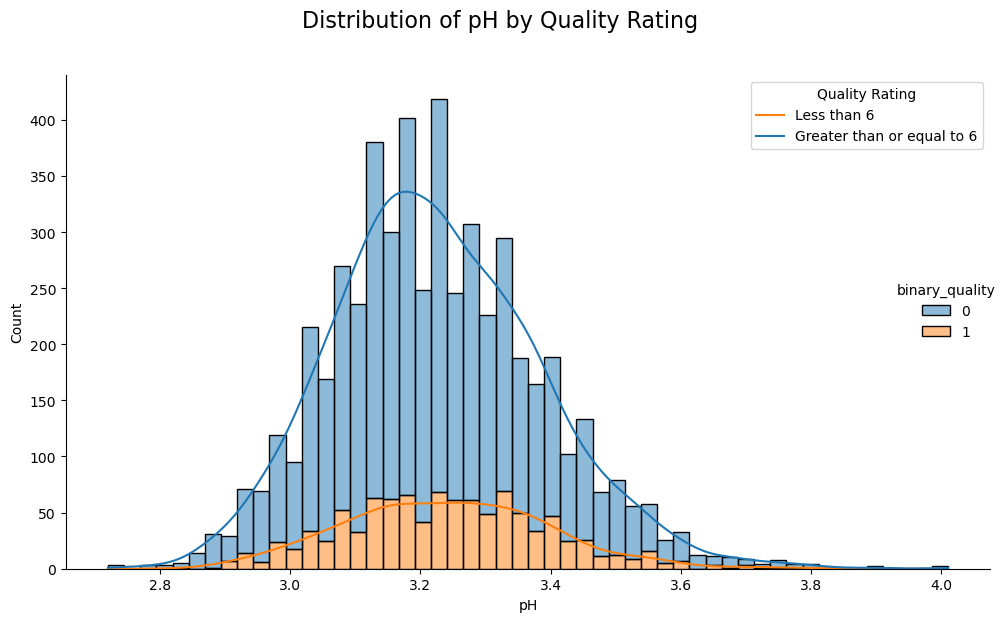

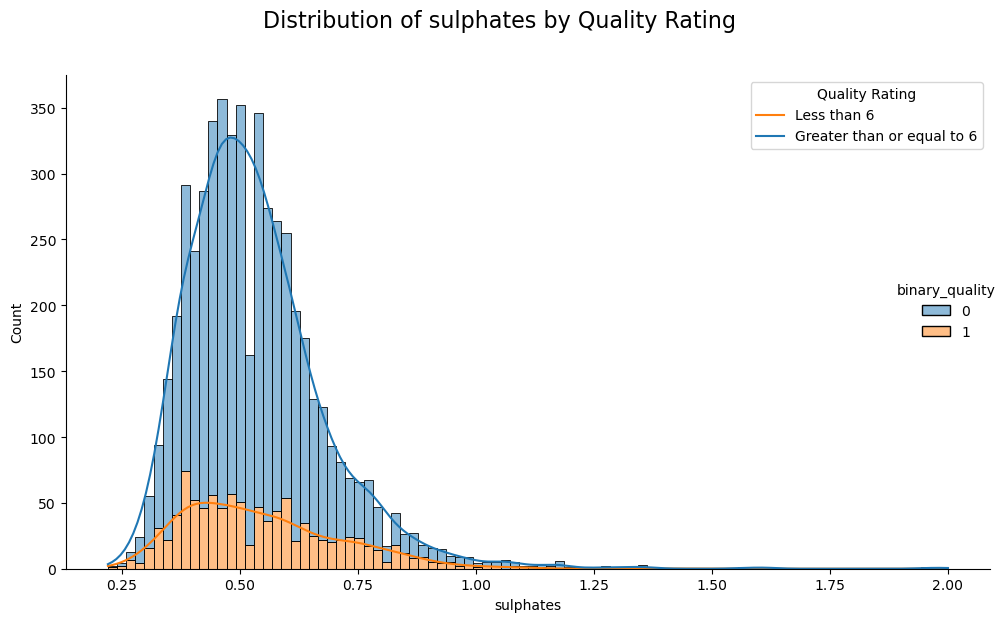

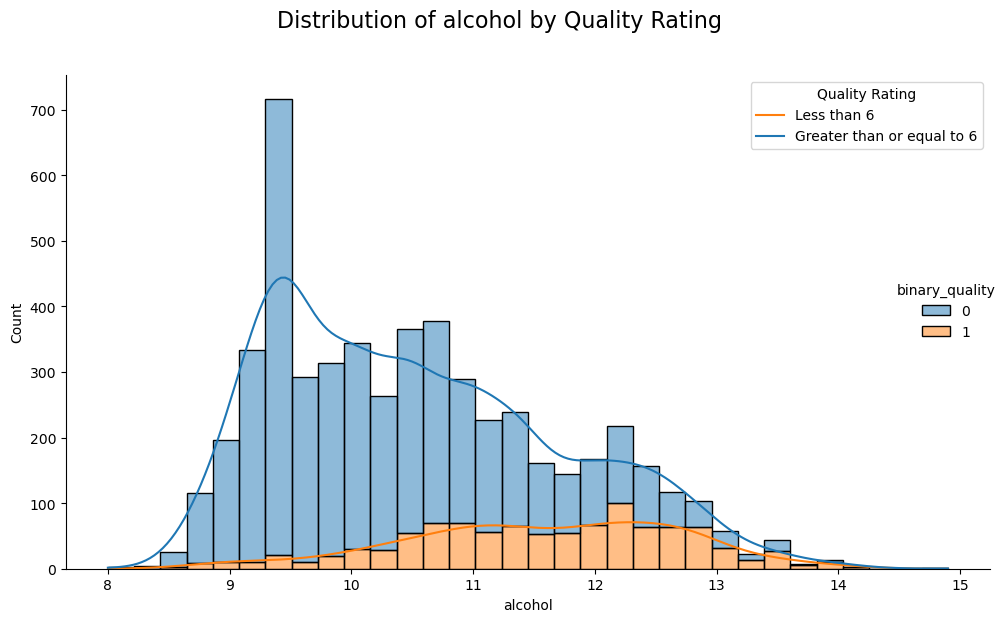

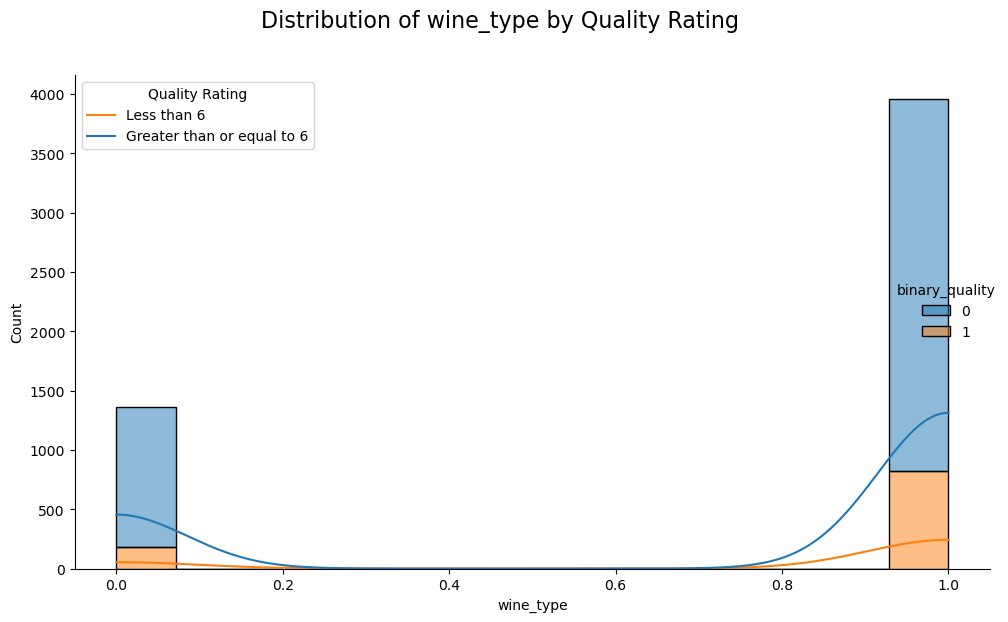

In [21]:
import seaborn as sns

for col in df.columns:
    if col != "binary_quality":
        g = sns.displot(data=df, x=col, hue="binary_quality", multiple="stack", kde=True, height=6, aspect=1.5)
        g.set_axis_labels(x_var=col, y_var="Count")
        g.fig.suptitle("Distribution of {} by Quality Rating".format(col), fontsize=16, y=1.03)
        g.fig.tight_layout()
        g.fig.subplots_adjust(top=0.92)
        g.ax.legend(title="Quality Rating", labels=["Less than 6", "Greater than or equal to 6"])


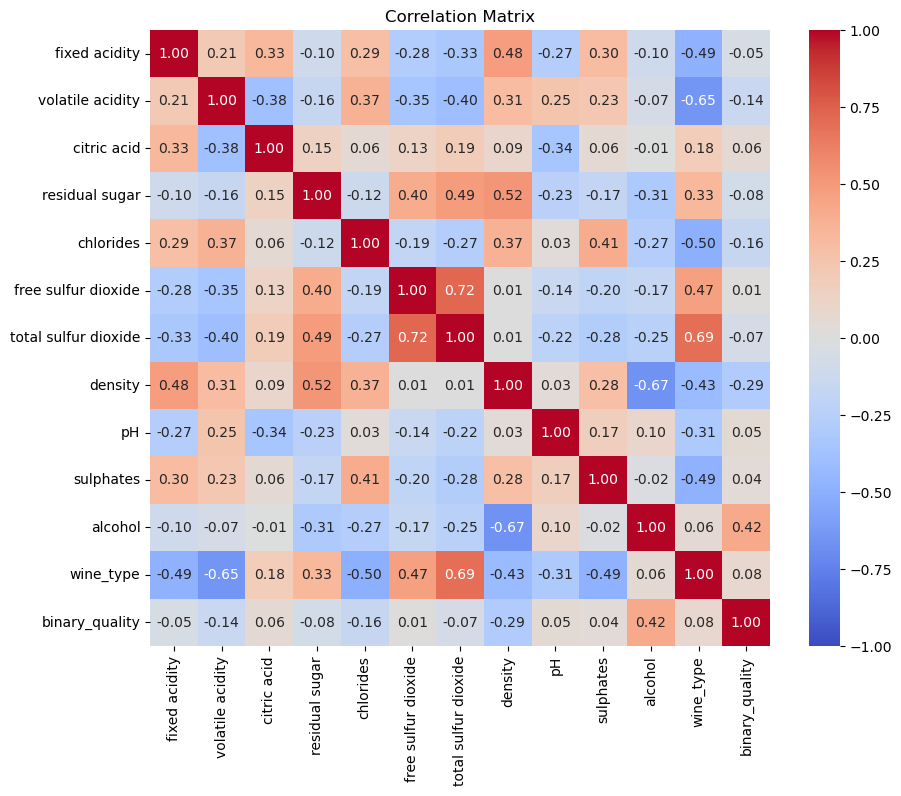

In [22]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [23]:
df.to_csv('winequality.csv')
